In [1]:
import os
from smolagents import tool, CodeAgent, LiteLLMModel
model = LiteLLMModel(model_id='gpt-4o', 
                     api_key=os.getenv("OPENAI_API_KEY"), 
                     timeout=60, # I'm still tier 1 ㅠ_ㅠ
                    )
import datetime
today = datetime.datetime.today().strftime('%Y%m%d')

import sqlite3
conn = sqlite3.connect("Chinook.db")

In [2]:
def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    create_tables = []
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    for table in tables.fetchall():
        table_names.append(table[0])
    return table_names

def get_column_metadata(conn, table_name):
    """Return a list of dictionaries containing metadata for each column."""
    column_metadata = []
    
    # Get column info (name, type, primary key)
    columns = conn.execute(f"PRAGMA table_info('{table_name}');").fetchall()
    for col in columns:
        col_name = col[1]
        col_type = col[2]
        is_primary_key = col[5] == 1  # PRAGMA table_info returns 1 for primary key columns

        column_metadata.append({
            "name": col_name,
            "type": col_type,
            "is_primary_key": is_primary_key,
            "is_foreign_key": False, 
            "references_table": None,
            "references_column": None
        })
    
    # Get foreign key info
    foreign_keys = conn.execute(f"PRAGMA foreign_key_list('{table_name}');").fetchall()
    for fk in foreign_keys:
        fk_column = fk[3]  # Column in the current table
        ref_table = fk[2]  # Referenced table
        ref_column = fk[4]  # Referenced column

        for col_meta in column_metadata:
            if col_meta["name"] == fk_column:
                col_meta["is_foreign_key"] = True
                col_meta["references_table"] = ref_table
                col_meta["references_column"] = ref_column
    
    return column_metadata

def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    table_names = get_table_names(conn)
    for table_name in table_names:
        columns_metadata = get_column_metadata(conn, table_name)
        table_dicts.append({"table_name": table_name, "columns": columns_metadata})
    return table_dicts
    

database_schema_dict = get_database_info(conn)
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\n" +
        "\n".join([
            f"  - Column: {col['name']} ({col['type']}), "
            f"Primary Key: {col['is_primary_key']}, "
            f"Foreign Key: {col['is_foreign_key']} "
            f"({'-> ' + col['references_table'] + '.' + col['references_column'] if col['is_foreign_key'] else ''})"
            for col in table["columns"]
        ])
        for table in database_schema_dict
    ]
)

In [3]:
@tool
def run_sql(query: str) -> list:
    """Executes an SQL query on the global database connection.

    Args:
        query: A valid SQL query.

    Returns:
        list: Query results as a list of tuples, or an error message as a string.
    """
    try:
        results = conn.execute(query).fetchall()
        return results  # Returns a list of tuples
    except Exception as e:
        return [f"Query failed with error: {e}"]  # Returns error as a list with one string element

@tool
def save_code(fpath: str, code: str) -> str:
    """Saves a piece of code at the specified file path.
    
    Args:
        fpath: Path and filename to save the code.
        code: Code snippet to save.
    
    Returns:
        str: Success message or error.
    """
    try:
        with open(fpath, 'w') as f:
            f.write(code)
        return f"Code successfully saved to {fpath}"
    except Exception as e:
        return f"Failed to save code: {e}"

agent = CodeAgent(
    model=model,
    tools=[run_sql],
    additional_authorized_imports=["matplotlib"],
    max_steps=20,
)

save_path = f'./output_{today}'
if not os.path.exists(save_path):
    os.makedirs(save_path)

prepend_sys_prompt = f"""Available SQL Database information including tables and schemas with data type, primary key and foreign key:
{database_schema_string}
\n\n"""

append_sys_prompt = f"""\n\nMake sure to save all codes you wrote under '{save_path}'. When you are finished \
with the task and generated all the necessary response and there is nothing else left for final_answer, \
then simply return 'Task completed'."""

agent.prompt_templates['system_prompt'] = prepend_sys_prompt + agent.prompt_templates['system_prompt'] + append_sys_prompt

In [4]:
task = "Find the total sales amount for each music genre and create a bar chart and save it as 'saves_vs_genre.png'"

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Find the total sales amount for each music genre and create a bar chart and save it as 'saves_vs_genre.png'     │
│                                                                                                                 │
╰─ LiteLLMModel - gpt-4o ─────────────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
To find the total sales amount for each music genre, we'll first need to perform the following steps:

1. Join the necessary tables to calculate the total sales amount per genre. The tables involved will include 
`genres`, `tracks`, `invoice_items`, and `invoices`.
2. Use SQL to sum up the sales (quantity * unit price) for each genre.
3. Extract these results into a format suitable for plotting.
4. Create a bar chart using matplotlib and save it as 'saves_vs_genre.png'.

Let's start executing these steps.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 0: Duration 2.29 seconds| Input tokens: 3,605 | Output tokens: 112]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  query = """                                                                                                      
  SELECT g.Name AS GenreName, SUM(ii.Quantity * ii.UnitPrice) AS TotalSales                                        
  FROM genres g                                                                                                    
  JOIN tracks t ON g.GenreId = t.GenreId                                                                           
  JOIN invoice_items ii ON t.TrackId = ii.TrackId                                                                  
  JOIN invoices i ON ii.InvoiceId = i.InvoiceId                                                                    
  GROUP BY g.Name                                                                                                  
  ORDER BY TotalSales DESC;                                                                                        
  """                                                                                                              
  sales_by_genre = run_sql(query=query)                                                                            
  print(sales_by_genre)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[('Rock', 826.65), ('Latin', 382.14), ('Metal', 261.36), ('Alternative & Punk', 241.56), ('TV Shows', 93.53), 
('Jazz', 79.2), ('Blues', 60.39), ('Drama', 57.71), ('R&B/Soul', 40.589999999999996), ('Classical', 
40.589999999999996), ('Sci Fi & Fantasy', 39.8), ('Reggae', 29.7), ('Pop', 27.72), ('Soundtrack', 19.8), ('Comedy',
17.91), ('Hip Hop/Rap', 16.83), ('Bossa Nova', 14.85), ('Alternative', 13.86), ('World', 12.87), ('Science 
Fiction', 11.94), ('Heavy Metal', 11.879999999999999), ('Electronica/Dance', 11.879999999999999), ('Easy 
Listening', 9.9), ('Rock And Roll', 5.9399999999999995)]

Out: None

[Step 1: Duration 1.77 seconds| Input tokens: 7,553 | Output tokens: 271]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



Error in generating model output:
litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'Rate limit 
reached for gpt-4o in organization org-MCJl6vR4SG3hNA3zVYjtDMEY on tokens per min (TPM): Limit 10000, Used 6638, 
Requested 4458. Please try again in 6.576s. Visit https://platform.openai.com/account/rate-limits to learn more.', 
'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

[Step 2: Duration 30.69 seconds| Input tokens: 11,501 | Output tokens: 430]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
                                                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 3: Duration 7.97 seconds| Input tokens: 16,173 | Output tokens: 430]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import matplotlib.pyplot as plt                                                                                  
                                                                                                                   
  # Data from previous SQL query                                                                                   
  sales_by_genre = [                                                                                               
      ('Rock', 826.65), ('Latin', 382.14), ('Metal', 261.36),                                                      
      ('Alternative & Punk', 241.56), ('TV Shows', 93.53),                                                         
      ('Jazz', 79.2), ('Blues', 60.39), ('Drama', 57.71),                                                          
      ('R&B/Soul', 40.59), ('Classical', 40.59), ('Sci Fi & Fantasy', 39.8),                                       
      ('Reggae', 29.7), ('Pop', 27.72), ('Soundtrack', 19.8),                                                      
      ('Comedy', 17.91), ('Hip Hop/Rap', 16.83), ('Bossa Nova', 14.85),                                            
      ('Alternative', 13.86), ('World', 12.87), ('Science Fiction', 11.94),                                        
      ('Heavy Metal', 11.88), ('Electronica/Dance', 11.88),                                                        
      ('Easy Listening', 9.9), ('Rock And Roll', 5.94)                                                             
  ]                                                                                                                
                                                                                                                   
  # Unpacking the data                                                                                             
  genres, sales = zip(*sales_by_genre)                                                                             
                                                                                                                   
  # Plot                                                                                                           
  plt.figure(figsize=(10, 8))                                                                                      
  plt.barh(genres, sales, color='skyblue')                                                                         
  plt.xlabel('Total Sales Amount')                                                                                 
  plt.title('Total Sales by Music Genre')                                                                          
  plt.gca().invert_yaxis()  # To have the highest sales on top                                                     
  plt.tight_layout()                                                                                    

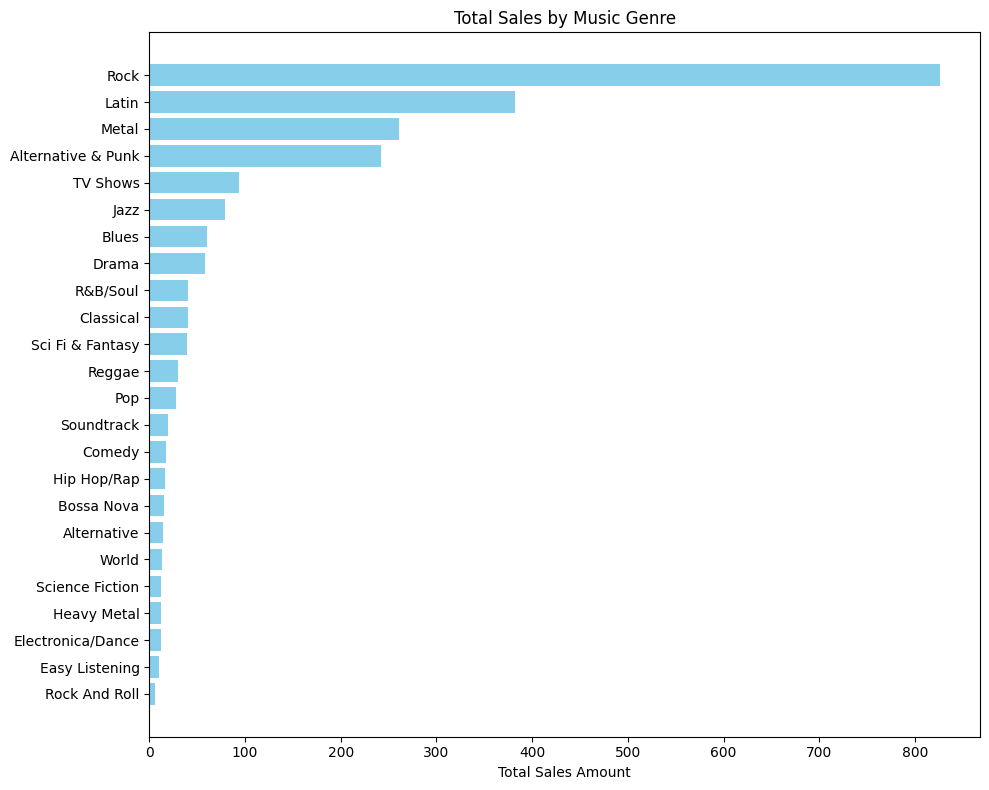

Out: None

[Step 4: Duration 32.35 seconds| Input tokens: 20,907 | Output tokens: 824]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
I've successfully generated and saved the bar chart as 'sales_vs_genre.png'. This chart visualizes the total sales 
amount for each music genre. 

Task completed.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 5: Duration 30.63 seconds| Input tokens: 26,479 | Output tokens: 857]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 7 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Task completed.")                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Task completed.

[Step 6: Duration 32.86 seconds| Input tokens: 32,236 | Output tokens: 904]

In [5]:
result = agent.run(task)